# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

In [1]:
import os
from pathlib import Path
import sys


NOTEBOOK_NAME = "C1_M5_Assignment_transferlearning.ipynb" #TODO: automate this
REPO_URL = "https://github.com/SDAIA-Bootcamps/ai-pros-v1-2025.git"

if 'google.colab' in sys.modules:
    print('in colab')
    if os.system('git config --get remote.origin.url') != REPO_URL:
        print('cloning...')
        !git clone $REPO_URL
        repo_dir = REPO_URL.split('/').pop().strip('.git')
        print(f'{repo_dir=}')
        labdir = next(Path(repo_dir).rglob(NOTEBOOK_NAME)).parent.absolute()
        print(f'{labdir=}')
        %cd $labdir

    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

# allow "hot-reloading" of modules
# %load_ext autoreload
# %autoreload 2
# needed for inline plots in some contexts
%matplotlib inline


!pwd
%ls

'pwd' is not recognized as an internal or external command,
operable program or batch file.


 Volume in drive C is Acer
 Volume Serial Number is 06AB-FE62

 Directory of c:\Users\Rubah\OneDrive\�� ���袠\DL models\ai-pros-v1-2025\W4_DL\C1_M5_TransferLearning

01/10/2026  02:14 PM    <DIR>          .
01/10/2026  02:13 PM    <DIR>          ..
01/10/2026  02:14 PM            16,975 C1_M5_Assignment_transferlearning.ipynb
01/10/2026  02:14 PM             7,439 helper_utils.py
               2 File(s)         24,414 bytes
               2 Dir(s)  277,056,962,560 bytes free


## Imports

In [29]:
# YOUR CODE HERE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import os
import random
import shutil
from pathlib import Path
from PIL import Image


from copy import deepcopy


## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [8]:
# YOUR CODE HERE
data_dir = Path(r"C:\Users\Rubah\OneDrive\سطح المكتب\DL models\ai-pros-v1-2025\W4_DL\C1_M5_TransferLearning\PetImages")

**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [12]:
# YOUR CODE HERE

target_dir = Path(r"C:\Users\Rubah\OneDrive\سطح المكتب\DL models\ai-pros-v1-2025\W4_DL\C1_M5_TransferLearning\dataset")

train_ratio = 0.8  
random.seed(42)

def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        return False

for cls in ["Cat", "Dog"]:
    images = list((data_dir / cls).glob("*.jpg"))
    images = [img for img in images if is_valid_image(img)]
    
    random.shuffle(images)
    split = int(len(images) * train_ratio)

    train_imgs = images[:split]
    test_imgs = images[split:]

    for img in train_imgs:
        dest = target_dir / "train" / cls
        dest.mkdir(parents=True, exist_ok=True)
        shutil.copy(img, dest / img.name)

    for img in test_imgs:
        dest = target_dir / "test" / cls
        dest.mkdir(parents=True, exist_ok=True)
        shutil.copy(img, dest / img.name)

print("Dataset successfully split into train and test!")



c:\Users\Rubah\OneDrive\سطح المكتب\DL models\venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dataset successfully split into train and test!


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [13]:
# YOUR CODE HERE
data_dir = Path(r"C:\Users\Rubah\OneDrive\سطح المكتب\DL models\ai-pros-v1-2025\W4_DL\C1_M5_TransferLearning\dataset")

train_dataset = ImageFolder(root=data_dir / "train")
test_dataset = ImageFolder(root=data_dir / "test")
print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))
print("Classes:", train_dataset.classes)

Train images: 19998
Test images: 5000
Classes: ['Cat', 'Dog']


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:** 

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [18]:
# YOUR CODE HERE
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [19]:
# YOUR CODE HERE
train_dataset = ImageFolder(root=data_dir / "train", transform=train_transforms)
test_dataset = ImageFolder(root=data_dir / "test", transform=test_transforms)

In [20]:

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


**Quick Check**: Visualize a batch of training images

In [16]:
helper_utils.visualize_batch?

Object `helper_utils.visualize_batch` not found.


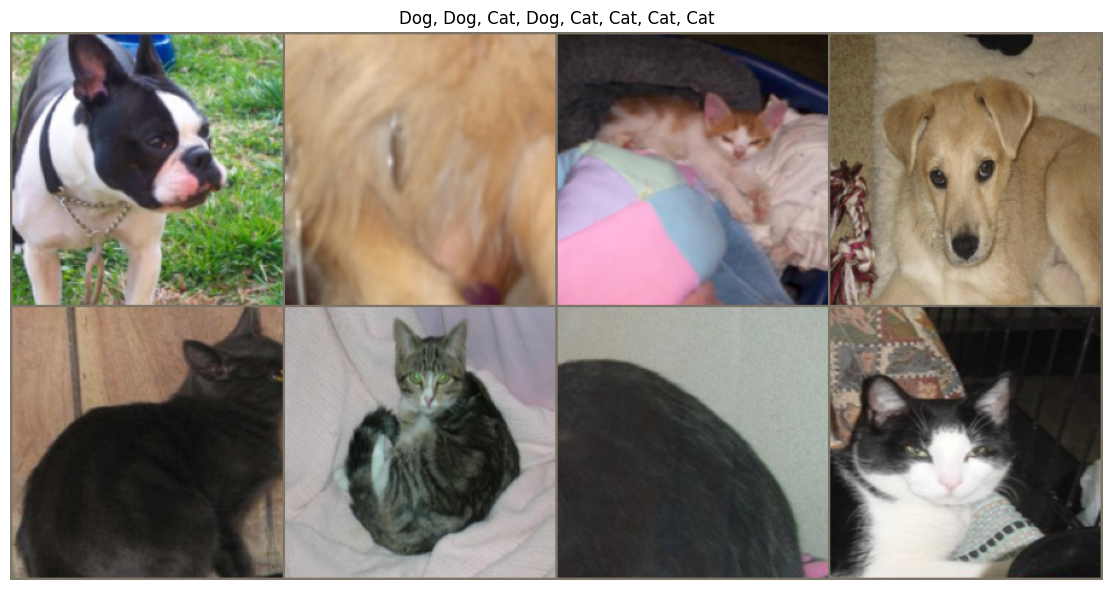

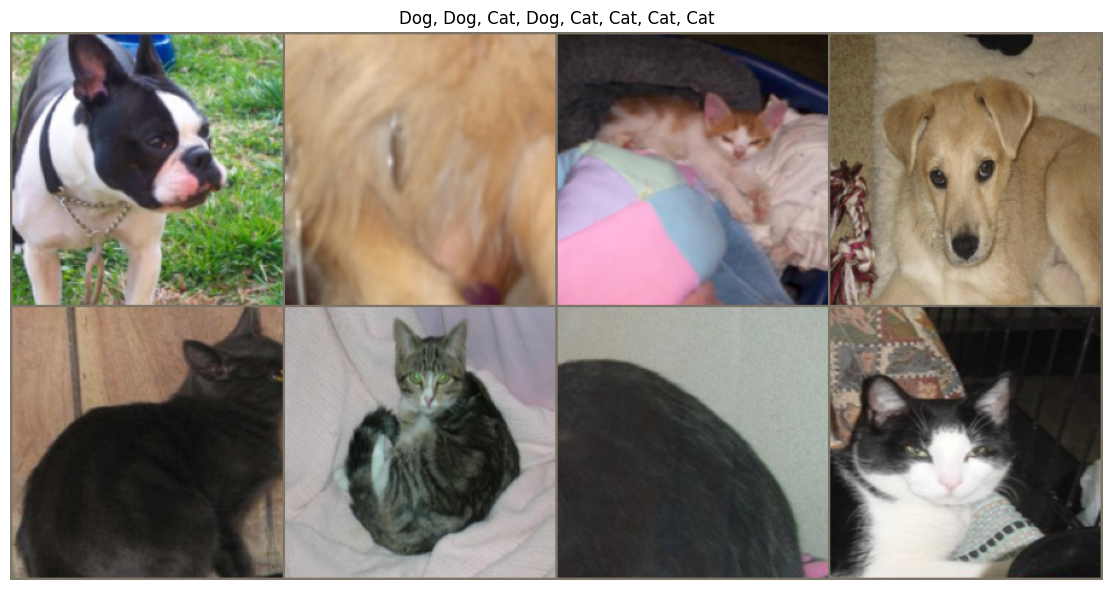

In [23]:
# YOUR CODE HERE
import helper_utils

helper_utils.visualize_batch(train_loader, train_dataset.classes)


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:** 

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# YOUR CODE HERE
model = models.resnet18(pretrained=True)

c:\Users\Rubah\OneDrive\سطح المكتب\DL models\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rubah\OneDrive\سطح المكتب\DL models\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
num_classes = len(train_dataset.classes)

for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

In [28]:
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [30]:
# YOUR CODE HERE
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print(f"{phase} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

    return model, history


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:** 

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [31]:
dataloaders = {
    'train': train_loader,
    'val': test_loader
}

In [32]:
# YOUR CODE HERE
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

model_conv, history_conv = train_model(
    model,
    dataloaders,
    criterion,
    optimizer_conv,
    device,
    num_epochs=5
)

Epoch 1/5
train - Loss: 0.1848 Acc: 0.9210
val - Loss: 0.0612 Acc: 0.9770
Epoch 2/5
train - Loss: 0.1581 Acc: 0.9325
val - Loss: 0.0593 Acc: 0.9782
Epoch 3/5
train - Loss: 0.1494 Acc: 0.9344
val - Loss: 0.0554 Acc: 0.9790
Epoch 4/5
train - Loss: 0.1498 Acc: 0.9343
val - Loss: 0.0507 Acc: 0.9806
Epoch 5/5
train - Loss: 0.1463 Acc: 0.9363
val - Loss: 0.0518 Acc: 0.9806


**Quick Check**: Visualize training history

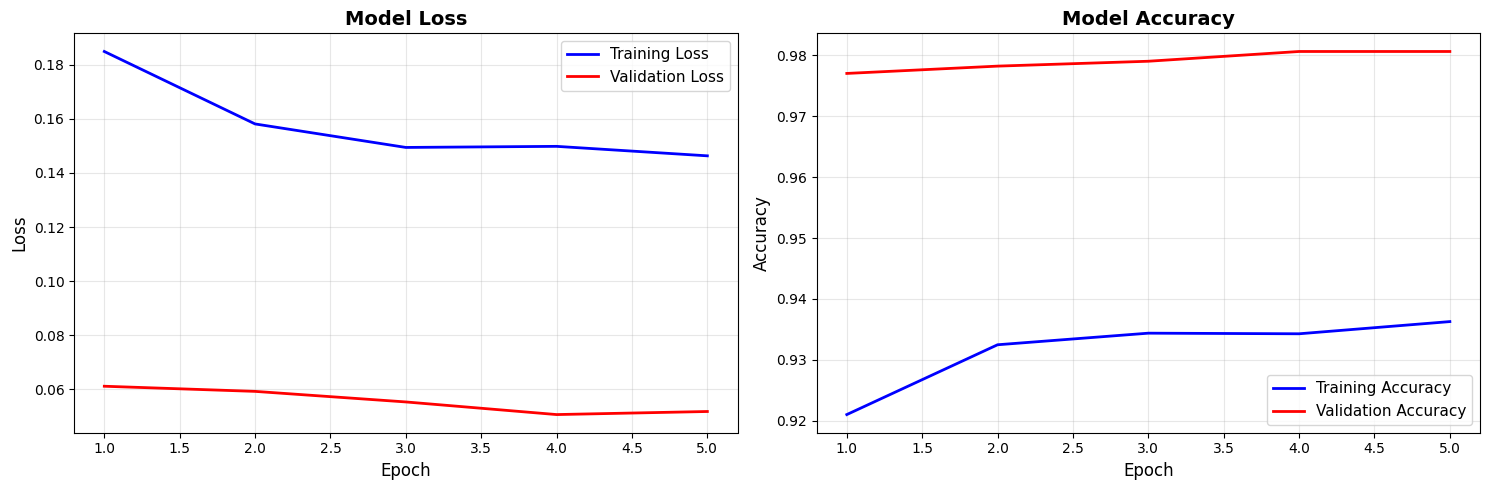

In [33]:
helper_utils.visualize_training_history(history_conv)
plt.show()

**Quick Check**: Visualize predictions

In [35]:
#helper_utils.visualize_predictions(model_conv, dataloaders['val'], num_classes, device, num_images=6)
#plt.show()

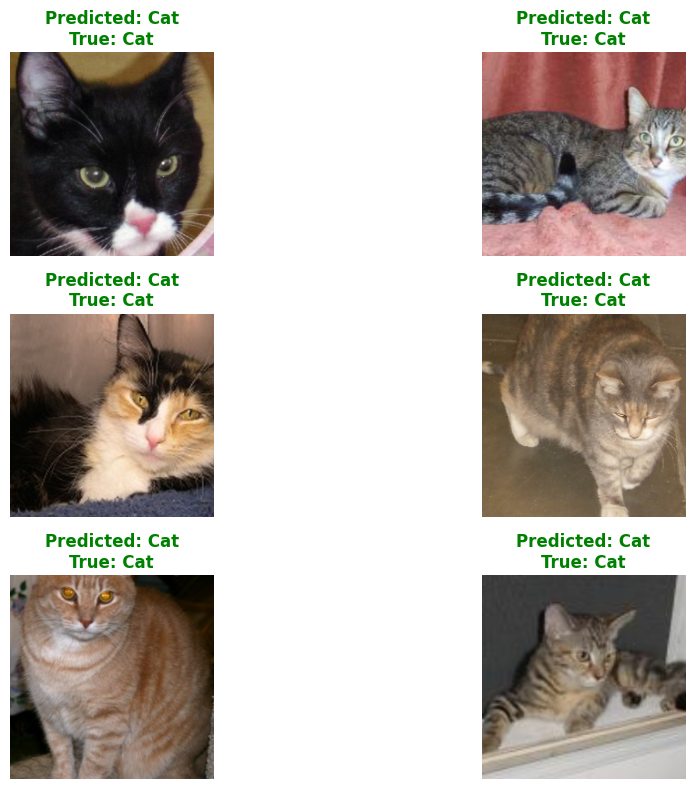

In [36]:
helper_utils.visualize_predictions(
    model_conv,
    dataloaders['val'],
    train_dataset.classes,
    device,
    num_images=6
)
plt.show()


<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [37]:
# YOUR CODE HERE
model_ft = models.resnet18(pretrained=True)


c:\Users\Rubah\OneDrive\سطح المكتب\DL models\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rubah\OneDrive\سطح المكتب\DL models\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# YOUR CODE HERE
num_classes = len(train_dataset.classes)
in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(in_features, num_classes)

In [39]:
# YOUR CODE HERE
for param in model_ft.parameters():
    param.requires_grad = True

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

model_ft = model_ft.to(device)

In [40]:
# YOUR CODE HERE
dataloaders = {
    'train': train_loader,
    'val': test_loader
}

model_ft, history_ft = train_model(
    model_ft,
    dataloaders,
    criterion,
    optimizer_ft,
    device,
    num_epochs=5  
)

Epoch 1/5
train - Loss: 0.2582 Acc: 0.9002
val - Loss: 0.0733 Acc: 0.9794
Epoch 2/5
train - Loss: 0.1500 Acc: 0.9393
val - Loss: 0.0521 Acc: 0.9848
Epoch 3/5
train - Loss: 0.1358 Acc: 0.9436
val - Loss: 0.0460 Acc: 0.9858
Epoch 4/5
train - Loss: 0.1243 Acc: 0.9477
val - Loss: 0.0392 Acc: 0.9874
Epoch 5/5
train - Loss: 0.1199 Acc: 0.9493
val - Loss: 0.0400 Acc: 0.9864


**Quick Check**: Visualize training history

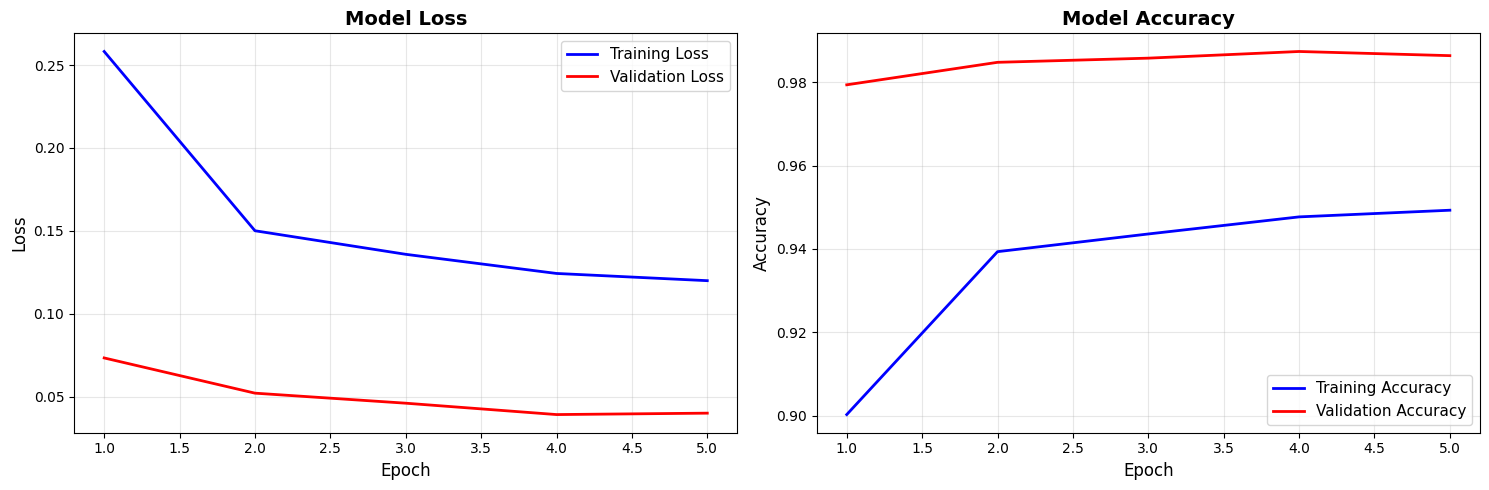

In [41]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

In [ ]:
# helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [42]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
# print("Feature Extractor Approach:")
# print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
# print()
# print("Fine-tuning Approach:")
# print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")
best_acc_conv = max(history_conv['val_acc'])
final_acc_conv = history_conv['val_acc'][-1]

best_acc_ft = max(history_ft['val_acc'])
final_acc_ft = history_ft['val_acc'][-1]

print("Feature Extractor Approach:")
print(f"  Best Val Accuracy: {best_acc_conv:.4f}")
print(f"  Final Val Accuracy: {final_acc_conv:.4f}\n")

print("Fine-tuning Approach:")
print(f"  Best Val Accuracy: {best_acc_ft:.4f}")
print(f"  Final Val Accuracy: {final_acc_ft:.4f}")


Feature Extractor Approach:
  Best Val Accuracy: 0.9806
  Final Val Accuracy: 0.9806

Fine-tuning Approach:
  Best Val Accuracy: 0.9874
  Final Val Accuracy: 0.9864


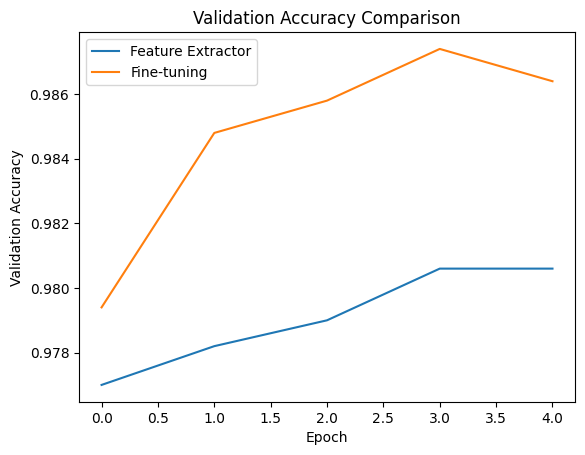

In [43]:
import matplotlib.pyplot as plt

plt.plot(history_conv['val_acc'], label='Feature Extractor')
plt.plot(history_ft['val_acc'], label='Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.show()

<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
# Make prediction on a custom image
# img_path = 'path/to/your/image.jpg'

# YOUR CODE HERE
# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
# helper_utils.visualize_single_prediction(
#     model_ft,  # or model_conv
#     img_path,
#     data_transforms['val'],
#     class_names,
#     device
# )
# plt.show()

Predicted Class: Cat


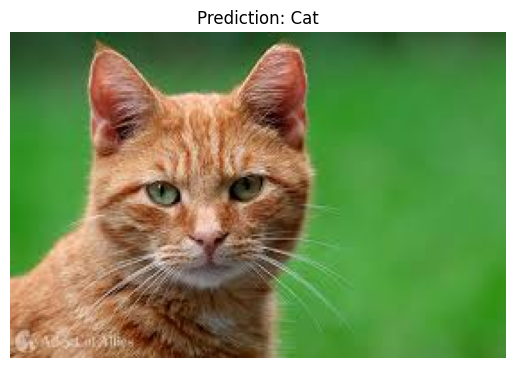

In [44]:
from PIL import Image
from torchvision import transforms

img_path = r"C:\Users\Rubah\OneDrive\سطح المكتب\DL models\ai-pros-v1-2025\W4_DL\C1_M5_TransferLearning\images.jpg"

img = Image.open(img_path).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img).unsqueeze(0).to(device)  # Add batch dimension

model_ft.eval()
with torch.no_grad():
    outputs = model_ft(input_tensor)
    _, predicted = torch.max(outputs, 1)

pred_class = train_dataset.classes[predicted.item()]
print(f"Predicted Class: {pred_class}")

import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"Prediction: {pred_class}")
plt.axis('off')
plt.show()


# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:** 
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:** 
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [ ]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")

In [ ]:
# Load ONNX model and perform inference
# YOUR CODE HERE

# Load ONNX model
# ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
# img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
# img_tensor = data_transforms['val'](img).unsqueeze(0)
# img_numpy = img_tensor.numpy()

# Run inference
# outputs = ort_session.run(None, {'input': img_numpy})
# predictions = np.array(outputs[0])
# pred_class_idx = np.argmax(predictions[0])
# pred_class = class_names[pred_class_idx]
# confidence = np.max(predictions[0])

# print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")